In [1]:
import glob
import os
import json
import pickle as pkl
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import utils_farouk as utils
plt.rcParams.update({"font.size": 20})

/opt/anaconda3/envs/coffea-env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
! ls ../Apr12_presel_2017

DYJetsToLL_Pt-100To250                  SingleElectron_Run2017F
DYJetsToLL_Pt-250To400                  SingleMuon_Run2017B
DYJetsToLL_Pt-400To650                  SingleMuon_Run2017C
DYJetsToLL_Pt-50To100                   SingleMuon_Run2017D
DYJetsToLL_Pt-650ToInf                  SingleMuon_Run2017E
GluGluHToTauTau                         SingleMuon_Run2017F
GluGluHToWW_Pt-200ToInf_M-125           TTTo2L2Nu
GluGluZH_HToWW_ZTo2L_M-125              TTToHadronic
HWminusJ_HToWW_M-125                    TTToSemiLeptonic
HWplusJ_HToWW_M-125                     VBFHToWWToLNuQQ_M-125_withDipoleRecoil
HZJ_HToWW_M-125                         WJetsToLNu_HT-100To200
QCD_Pt_1000to1400                       WJetsToLNu_HT-1200To2500
QCD_Pt_1400to1800                       WJetsToLNu_HT-200To400
QCD_Pt_170to300                         WJetsToLNu_HT-2500ToInf
QCD_Pt_1800to2400                       WJetsToLNu_HT-400To600
QCD_Pt_2400to3200                       WJetsToLNu_HT-600To800
QCD_Pt_300to470 

# Read cutflows from pkl

In [4]:
year = "2017"
channels = ["mu", "ele"]
samples_dir = f"../Apr12_presel_{year}"

samples = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
#     "Data"
]

In [5]:
combine_samples = {
    # data
    # "SingleElectron_": "SingleElectron",
    "SingleElectron_": "Data",
    # "SingleMuon_": "SingleMuon_",
    "SingleMuon_": "Data",
    # "EGamma_": "EGamma",
    "EGamma_": "Data",
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "HWW",
    "HToWW_M-125": "VH",
    "VBFHToWWToLNuQQ_M-125_withDipoleRecoil": "VBF",
    "ttHToNonbb_M125": "ttH",
    # bkg
    "QCD_Pt": "QCD",
    "DYJets": "DYJets",
    "WJetsToLNu_": "WJetsLNu",
    "JetsToQQ": "WZQQ",
    "TT": "TTbar",
    "ST_": "SingleTop",
    "WW": "Diboson",
    "WZ": "Diboson",
    "ZZ": "Diboson",
}

def get_sum_sumgenweight(pkl_files, year, sample):
    sum_sumgenweight = 0
    for ifile in pkl_files:
        # load and sum the sumgenweight of each
        with open(ifile, "rb") as f:
            metadata = pkl.load(f)
        sum_sumgenweight = sum_sumgenweight + metadata[sample][year]["sumgenweight"]
    return sum_sumgenweight


def get_xsecweight(pkl_files, year, sample, is_data, luminosity):
    if not is_data:
        # find xsection
        f = open("../fileset/xsec_pfnano.json")
        xsec = json.load(f)
        f.close()
        try:
            xsec = eval(str((xsec[sample])))
        except ValueError:
            print(f"sample {sample} doesn't have xsecs defined in xsec_pfnano.json so will skip it")
            return None

        # get overall weighting of events.. each event has a genweight...
        # sumgenweight sums over events in a chunk... sum_sumgenweight sums over chunks
        xsec_weight = (xsec * luminosity) / get_sum_sumgenweight(pkl_files, year, sample)
    else:
        xsec_weight = 1
    return xsec_weight

def get_cutflow(pkl_files, year, sample, weight, ch):
    """
    Get cutflow from metadata but multiply by xsec-weight
    """
    cuts = {}
    cuts["mu"] = ["trigger", 
            "metfilters", 
            "leptonKin", 
            "fatjetKin", 
            "ht", 
            "oneLepton", 
            "notaus", 
            "leptonInJet", 
            "lep_isolation", 
            "lep_misolation"
           ]
    cuts["ele"] = cuts["mu"][:-1]  # remove lep_misolation
    
    evyield = dict.fromkeys(cuts[ch], 0)
    for ik, pkl_file in enumerate(pkl_files):
        with open(pkl_file, "rb") as f:
            metadata = pkl.load(f)
            if ch == "lep":
                cutflows = metadata[sample][year]["cutflows"]
            else:
                cutflows = metadata[sample][year]["cutflows"][ch]

            for key in evyield.keys():
                evyield[key] += cutflows[key] * weight
    return evyield

In [6]:
cutflows = {}
for ch in channels:
    cutflows[ch] = {}

    # get lumi
    with open("../fileset/luminosity.json") as f:
        luminosity = json.load(f)[ch][year]

    condor_dir = os.listdir(samples_dir)
    
    for sample in condor_dir:

        # get a combined label to combine samples of the same process
        for key in combine_samples:
            if key in sample:
                sample_to_use = combine_samples[key]
                break
            else:
                sample_to_use = sample

        if sample_to_use not in samples:
            continue

        is_data = False
        # if sample_to_use == data_by_ch[ch]:
        if sample_to_use == "Data":
            is_data = True

        print(f"Finding {sample} samples and should combine them under {sample_to_use}")

        out_files = f"{samples_dir}/{sample}/outfiles/"
        parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
        pkl_files = glob.glob(f"{out_files}/*.pkl")

        if not parquet_files:
            print(f"No parquet file for {sample}")
            continue

        data = pd.read_parquet(parquet_files)
        if len(data) == 0:
            continue

        xsec_weight = get_xsecweight(pkl_files, year, sample, is_data, luminosity)
        if sample_to_use not in cutflows[ch].keys():
            cutflows[ch][sample_to_use] = get_cutflow(pkl_files, year, sample, xsec_weight, ch)
        else:
            temp = get_cutflow(pkl_files, year, sample, xsec_weight, ch)
            for key in cutflows[ch][sample_to_use]:
                cutflows[ch][sample_to_use][key] += temp[key]

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
Finding TTToSemiLeptonic samples and should combine them under TTbar
Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
Finding GluGluHToWW_Pt-200ToInf_M-125 sam

In [7]:
cutflows["mu"]["WJetsLNu"]

{'trigger': 20157346.06134652,
 'metfilters': 20147389.161279302,
 'leptonKin': 18013061.95110634,
 'fatjetKin': 1131485.9738889704,
 'ht': 1126454.2250033882,
 'oneLepton': 1115538.4489213594,
 'notaus': 994737.4117575842,
 'leptonInJet': 347622.0114433662,
 'lep_isolation': 345012.30051213596,
 'lep_misolation': 338939.3104419345}

In [8]:
# combine both channels
cutflows_combined = {}
for ch in cutflows:
    for sample in cutflows[ch]:
        if sample not in cutflows_combined:
            cutflows_combined[sample] = {}
            
        for cut in cutflows[ch][sample]:
            if cut not in cutflows_combined[sample]:
                cutflows_combined[sample][cut] = cutflows[ch][sample][cut]
            else:
                cutflows_combined[sample][cut] += cutflows[ch][sample][cut]

In [9]:
cutflows_combined["HWW"]

{'trigger': 2098.62910836108,
 'metfilters': 2096.0964258694066,
 'leptonKin': 1798.2018564527923,
 'fatjetKin': 1516.5751427049534,
 'ht': 1515.1304463174693,
 'oneLepton': 1283.5505299185988,
 'notaus': 1109.7778417149568,
 'leptonInJet': 635.2390011455686,
 'lep_isolation': 618.2236579970337,
 'lep_misolation': 344.1209325876088}

# Plot cutflows

In [12]:
plt.rcParams.update({"font.size": 20})

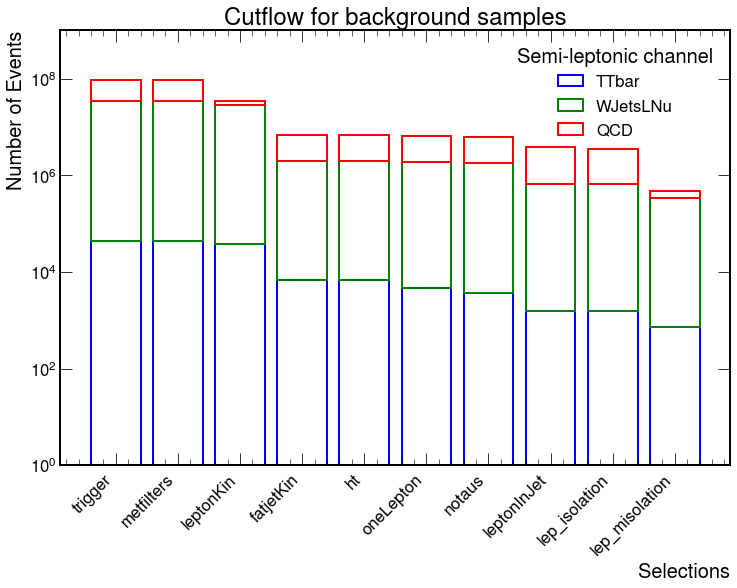

In [13]:
samples = [
#     "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
    "QCD",
#     "DYJets",
    "WJetsLNu",
#     "WZQQ",
    "TTbar",
#     "SingleTop",
#     "Diboson",
#     "Data"
]

colors = ['blue', 'green', 'red']

labels = list(cutflows_combined[samples[0]].keys())
values = [[cutflows_combined[sample][label] for label in labels] for sample in samples]

# Sort the samples by yield
sorted_idx = sorted(range(len(values)), key=lambda i: sum(values[i]), reverse=False)
samples = [samples[i] for i in sorted_idx]
values = [values[i] for i in sorted_idx]

fig, ax = plt.subplots(figsize=(12, 8))
# Plot the cutflows as a stacked bar chart for each sample
bottom = [0] * len(labels)
for i, sample in enumerate(samples):
    if all(v == 0 for v in values[i]):
        print(f"Sample {sample} is empty")
        continue    
    ax.bar(labels, values[i], bottom=bottom, label=sample, edgecolor=colors[i%len(colors)], linewidth=2, fill=False)
    bottom = [sum(x) for x in zip(bottom, values[i])]
    
plt.xticks(rotation=45, ha='right')

ax.set_xlabel('Selections')
ax.set_ylabel('Number of Events')
ax.legend(title="Semi-leptonic channel")
ax.set_yscale("log")
ax.set_ylim(1,10**9)
ax.set_title('Cutflow for background samples');

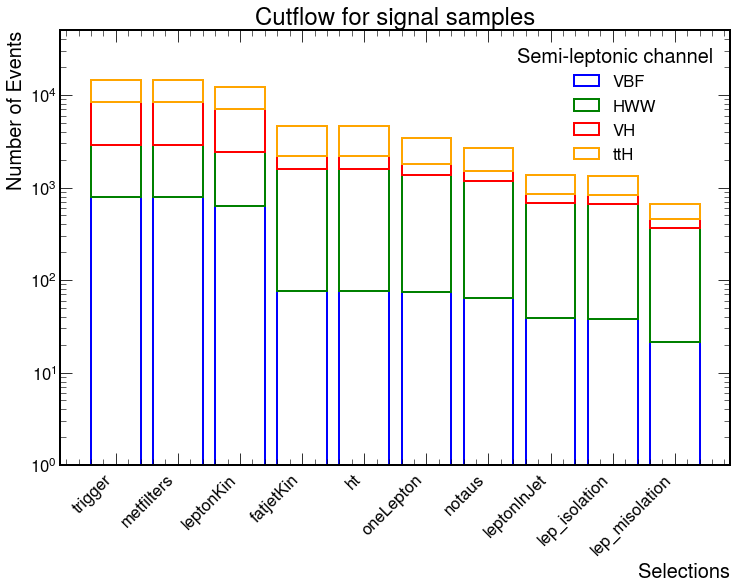

In [14]:
# for signal
samples = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
#     "QCD",
#     "DYJets",
#     "WJetsLNu",
#     "WZQQ",
#     "TTbar",
#     "SingleTop",
#     "Diboson",
#     "Data"
]

colors = ['blue', 'green', 'red', 'orange']

labels = list(cutflows_combined[samples[0]].keys())
values = [[cutflows_combined[sample][label] for label in labels] for sample in samples]

# Sort the samples by yield
sorted_idx = sorted(range(len(values)), key=lambda i: sum(values[i]), reverse=False)
samples = [samples[i] for i in sorted_idx]
values = [values[i] for i in sorted_idx]

fig, ax = plt.subplots(figsize=(12, 8))
# Plot the cutflows as a stacked bar chart for each sample
bottom = [0] * len(labels)
for i, sample in enumerate(samples):
    if all(v == 0 for v in values[i]):
        print(f"Sample {sample} is empty")
        continue    
    ax.bar(labels, values[i], bottom=bottom, label=sample, edgecolor=colors[i%len(colors)], linewidth=2, fill=False)
    bottom = [sum(x) for x in zip(bottom, values[i])]
    
plt.xticks(rotation=45, ha='right')

ax.set_xlabel('Selections')
ax.set_ylabel('Number of Events')
ax.legend(title="Semi-leptonic channel")
ax.set_yscale("log")
ax.set_ylim(1,5*10**4)
ax.set_title('Cutflow for signal samples');